<a href="https://colab.research.google.com/github/golesuman/66-daysofdatachallenge/blob/main/Day53/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch 
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

In [6]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform=transforms.Compose([transforms.Resize(64),
                             transforms.ToTensor(),
                             ])
dataset=datasets.FashionMNIST(root='./data',download=True,train=True,transform=transform)
data_loader=DataLoader(dataset,shuffle=True,batch_size=32,num_workers=8)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


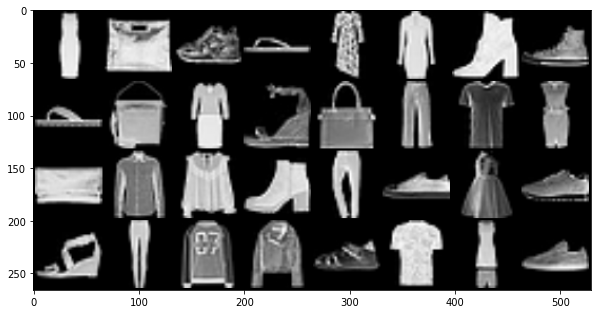

In [11]:

from torchvision.utils import make_grid
plt.figure(figsize=(10,10))
data,labels=next(iter(data_loader))
grid_img=make_grid(data,nrow=8)
plt.imshow(grid_img.permute(1,2,0))

In [33]:
CODING_SIZE=100
class Generator(nn.Module):
  def __init__(self,coding_sz):
    super(Generator,self).__init__()
    self.net=nn.Sequential(
        nn.ConvTranspose2d(coding_sz,1024,4,1,0),
        nn.BatchNorm2d(1024),
        nn.ReLU(),
        nn.ConvTranspose2d(1024,512,4,2,1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.ConvTranspose2d(512,256,4,2,1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.ConvTranspose2d(256,128,4,2,1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(128,1,4,2,1),
        nn.Tanh())
        
  def forward(self,x):
    return self.net(x)



netG=Generator(CODING_SIZE).to(device)

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.net=nn.Sequential(
        nn.Conv2d(1,128,4,2,1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128,256,4,2,1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),
        nn.Conv2d(256,512,4,2,1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),
        nn.Conv2d(512,1024,4,2,1),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024,1,4,1,0),
        nn.Sigmoid())
  
  def forward(self,x):
    return self.net(x)


netD=Discriminator().to(device)




In [34]:
def weights_init(m):
  classname=m.__class__.__name__
  if classname.find('Conv')!=-1:
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('BatchNorm')!=-1:
    nn.init.normal_(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)

netG.apply(weights_init)
netD.apply(weights_init)


Discriminator(
  (net): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

In [35]:
criterion=nn.BCELoss()
optimizerG=optim.Adam(netG.parameters(),lr=0.0002,betas=(0.5,0.999))
optimizerD=optim.Adam(netD.parameters(),lr=0.0001,betas=(0.5,0.999))
real_labels=torch.full((32,),1.0,dtype=torch.float,device=device)
fake_labels=torch.full((32,),0.,dtype=torch.float,device=device)

print(real_labels)
print(fake_labels)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


In [ ]:
G_losses=[]
D_losses=[]
D_real=[]
D_fake=[]
z=torch.randn((32,100)).view(-1,100,1,1).to(device)
test_out_images=[]
n_epochs=5

for epoch in range(n_epochs):
  print(f'Epoch:{epoch+1}')
  for i, batch in enumerate(data_loader):
    if (i%200==0):
      print(f'batch:{i} of {len(data_loader)}')

    optimizerD.zero_grad()

    real_images=batch[0].to(device)*2.-1.
    output=netD(real_images).view(-1)
    errD_real=criterion(output,real_labels)
    D_x=output.mean().item()
    noise=torch.randn((32,100))
    noise=noise.view(-1,100,1,1).to(device)
    fake_images=netG(noise)
    output=netD(fake_images).view(-1)
    errD_fake=criterion(output,fake_labels)
    D_G_z1=output.mean().item()
    errD=errD_real+errD_fake
    errD.backward(retain_graph=True)
    optimizerD.step()

    netG.zero_grad()
    output=netD(fake_images).view(-1)
    errG=criterion(output,real_labels)
    errG.backward()
    D_G_z2=output.mean().item()
    optimizerG.step()
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    D_real.append(D_x)
    D_fake.append(D_G_z2)

    test_images=netG(z).to('cpu').detach()
    test_out_images.append(test_images)

Epoch:1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


batch:0 of 1875
batch:200 of 1875
batch:400 of 1875
batch:600 of 1875
batch:800 of 1875
